# Importing Required Libraries 

In [1]:
import os
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image


import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Data Exploration 

In [2]:
# Define the path to the dataset
train_dir = '/Users/ifeanyinwaneri/Documents/Documents - Ifeanyi’s MacBook Pro/Computer-Vision-Model/CSE-Project Dataset/vggface/train'
test_dir = '/Users/ifeanyinwaneri/Documents/Documents - Ifeanyi’s MacBook Pro/Computer-Vision-Model/CSE-Project Dataset/vggface/test'

# 1. Count the number of classes (folders)
train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)

print(f"Number of training classes (identities): {len(train_classes)}")
print(f"Number of testing classes (identities): {len(test_classes)}")

Number of training classes (identities): 8631
Number of testing classes (identities): 501


In [3]:
# 2. Count the number of images in each class
train_image_counts = {cls: len(os.listdir(os.path.join(train_dir, cls)))
                      for cls in train_classes if os.path.isdir(os.path.join(train_dir, cls))}

test_image_counts = {cls: len(os.listdir(os.path.join(test_dir, cls)))
                     for cls in test_classes if os.path.isdir(os.path.join(test_dir, cls))}

# Print some statistics
print(f"Average images per class (training): {sum(train_image_counts.values()) / len(train_image_counts):.2f}")
print(f"Average images per class (testing): {sum(test_image_counts.values()) / len(test_image_counts):.2f}")


Average images per class (training): 364.02
Average images per class (testing): 338.79


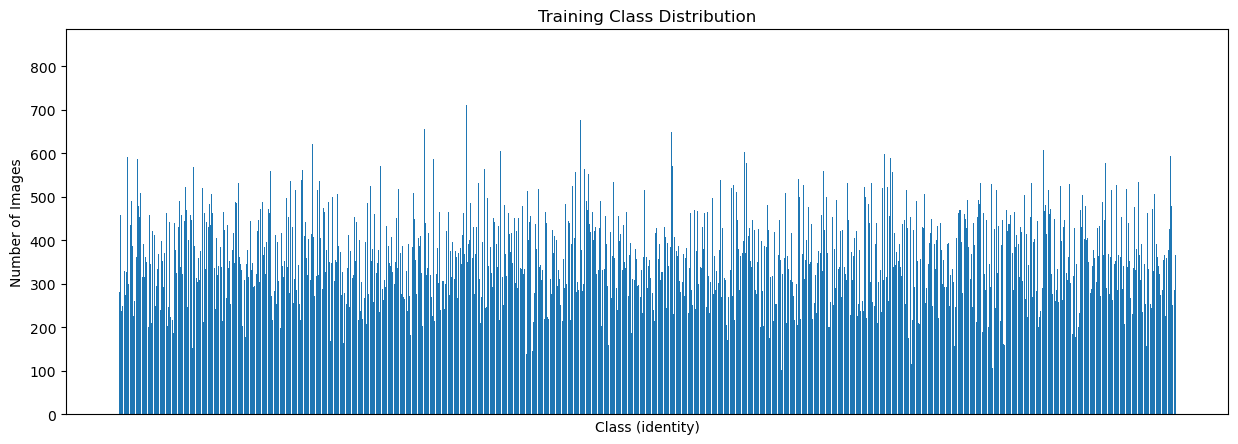

Sample Images from Training Set:


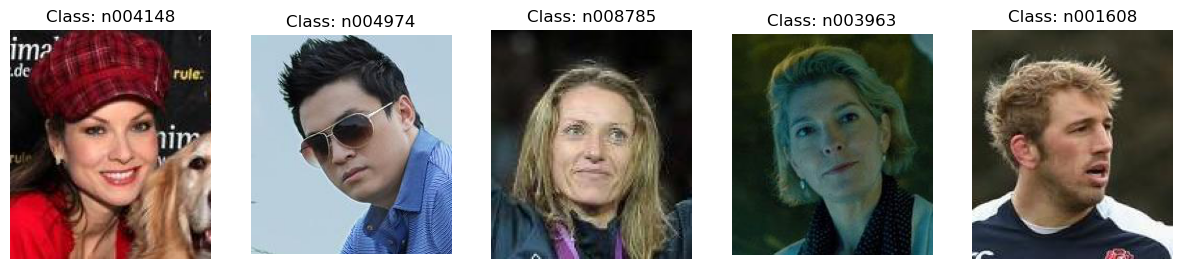

In [4]:
# 3. Check for class imbalance
plt.figure(figsize=(15, 5))
plt.bar(train_image_counts.keys(), train_image_counts.values())
plt.title('Training Class Distribution')
plt.xlabel('Class (identity)')
plt.ylabel('Number of Images')
plt.xticks([], [])  # Remove x-tick labels for readability
plt.show()

# 4. Display a few sample images from the dataset
def plot_sample_images(dataset_path, classes, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(classes[:num_samples]):
        class_folder = os.path.join(dataset_path, cls)
        sample_image_path = os.path.join(class_folder, os.listdir(class_folder)[0])
        image = Image.open(sample_image_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {cls}")
        plt.axis('off')
    plt.show()

# Show 5 sample images from the training set
print("Sample Images from Training Set:")
plot_sample_images(train_dir, train_classes)


In [5]:
# Get the class IDs (subdirectory names) for training and testing
train_classes = set(os.listdir(train_dir))
test_classes = set(os.listdir(test_dir))

# Remove hidden files like .DS_Store (if any exist)
train_classes.discard('.DS_Store')
test_classes.discard('.DS_Store')

# Find overlapping identities
overlapping_classes = train_classes.intersection(test_classes)

# Print results
print(f"Number of training classes: {len(train_classes)}")
print(f"Number of testing classes: {len(test_classes)}")
print(f"Number of overlapping classes: {len(overlapping_classes)}")

if overlapping_classes:
    print("Overlapping classes:")
    for cls in overlapping_classes:
        print(cls)
else:
    print("No overlapping classes found.")


Number of training classes: 8631
Number of testing classes: 500
Number of overlapping classes: 0
No overlapping classes found.


In [6]:
# Parameters
IMG_SIZE = 224  # Image size for resizing
BATCH_SIZE = 32  # Batch size for data generators


# Helper function to load and preprocess images
def preprocess_images(directory, img_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))  # Ensure consistent order
    class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
    
    for cls in class_names:
        cls_path = os.path.join(directory, cls)
        if not os.path.isdir(cls_path):
            continue
        for img_file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_file)
            try:
                img = Image.open(img_path).convert("RGB")  # Ensure 3 channels
                img = img.resize((img_size, img_size))  # Resize image
                images.append(np.array(img) / 255.0)  # Normalize to [0, 1]
                labels.append(class_to_idx[cls])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

In [12]:
# Parameters
IMG_SIZE = 224  # Image size for resizing
BATCH_SIZE = 16  # Batch size
AUTOTUNE = tf.data.AUTOTUNE
TRAIN_RATIO = 0.5  # Use 10% of the original data
VAL_SPLIT = 0.1  # Split 10% of training data for validation


# Load training dataset
original_train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load testing dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3141890 files belonging to 8631 classes.


2024-12-08 21:10:31.794669: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-12-08 21:10:31.794705: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2024-12-08 21:10:31.794713: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2024-12-08 21:10:31.794731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-08 21:10:31.794742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 169396 files belonging to 500 classes.


In [13]:
# Extract class names
class_names = original_train_dataset.class_names
num_classes = len(class_names)  # Number of classes

# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = original_train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Cache and prefetch for performance
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Reduce the size of the training dataset to 20% of the original data
train_dataset = train_dataset.take(int(len(train_dataset) * TRAIN_RATIO))

# Split the reduced training dataset into train and validation sets
val_size = int(len(train_dataset) * VAL_SPLIT)
val_dataset = train_dataset.take(val_size)
train_dataset = train_dataset.skip(val_size)

# Display dataset statistics
print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Testing batches: {len(test_dataset)}")

Training batches: 88366
Validation batches: 9818
Testing batches: 10588


In [ ]:
# Build the model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add classification head
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Use `num_classes` here

model = Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,  # Use fewer epochs for quick testing
    verbose=1
)

Epoch 1/2


2024-12-08 21:10:36.643620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10655/88366 ━━━━━━━━━━━━━━━━━━━━ 26:42 21ms/step - accuracy: 4.5200e-04 - loss: 8.9280

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,  # Use fewer epochs for quick testing
    verbose=1
)

In [41]:
torch.backends.mps.is_available()

True

In [ ]:
# Save the trained model
model.save('facial_identification_head.h5')